
---

# CORAL Models for Behavior Prediction under Distribution Shift

**Author:** Medha Agarwal
**Last Modified:** December 03, 2025

This notebook demonstrates the use of **CORrelation ALignment (CORAL)** for domain adaptation in wildlife behavior prediction, transferring models trained on **Vectronics acceleration data** to the **RVC dataset**, which exhibits a distinct distribution shift. The workflow includes preprocessing, model training, calibration, and evaluation across both domains.

The notebook expects the following preprocessed data files to be available in the `data/` directory:

* `Vectronics_preprocessed_duration30.0.csv` — generated by `scripts/run_Vectronics_preprocessing.py`
* `Vectronics_full_summary.csv` — generated by `scripts/run_Vectronics_preprocessing.py`
* `RVC_preprocessed.csv` — generated by `scripts/run_RVC_preprocessing.py`
* `matched_sightings.csv` — generated by `src/eval/sightings.py`
* `matched_gps.csv` — generated by `src/eval/GPS_labels.py`
* `GPS_moving.csv` — generated by `src/eval/GPS_labels.py`
* `GPS_clusters.csv` — generated by `src/eval/sightings.py`

---


In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
# Import modules
import sys
sys.path.append(".")
sys.path.append("../")
sys.path.append("../../")
import os
import yaml
import json
import numpy as np
import pandas as pd

import torch
from torch.utils.data import DataLoader

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [3]:
# Script imports

import config as config

# utility functions
import src.utils.io as io
import src.utils.preprocess as preprocess
from src.utils.data_prep import setup_multilabel_dataloaders
import src.utils.datasets as datasets
from src.utils.train import train_coral
from src.utils.Vectronics_preprocessing import modify_vectronics_labels
from src.utils.plots import multi_label_predictions, plot_multiclass_roc
import src.utils.functionalities as func

# method functions
from src.methods.coral import SimpleFeatureNet
from src.methods.calibration import calibration

# evaluation functions
from src.eval.eval_utils import evaluate_multilabel_distribution
from src.eval.plot_utils import make_sightings_plots_from_model

In [4]:
# Graphing Parameters
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rcParams['lines.markersize'] = 12
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['xtick.labelsize'] = 25
mpl.rcParams['ytick.labelsize'] = 25
mpl.rcParams["axes.labelsize"] = 25
mpl.rcParams['legend.fontsize'] = 20
mpl.rcParams['axes.titlesize'] = 25
mpl.rcParams['text.usetex'] = True

In [5]:
np.random.seed(seed=0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)

In [ ]:
args_df = pd.DataFrame([{

    # ---------------- Feature setup ----------------
    "pos_idx": [0,1,2,3,4,5],
    "center_idx": None,
    "remove_outliers": 1,
    # ---------------- Preprocessing ----------------
    "n_sample_per_target": 200000,
    # ---------------- Model ----------------
    "feat_dim": 128,
    "label_config": "B",
    # ---------------- Training ----------------
    "theta": 0.3,
    "num_epochs": 100,
    "batch_size": 512,
    "learning_rate": 1e-3,
    "weight_decay": 0.0,
    "lambda_coral": 1.0,
    "test_frac": 0.2,
    "device": 0,
    "seed": 0
}])

class Objectify(dict):
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__

args = Objectify(args_df.iloc[0].to_dict())
device='cpu'
# device = torch.device(f"cuda:{args.device}" if torch.cuda.is_available() else "cpu")
results_dir = os.path.join(io.get_domain_adaptation_results_dir(), "coral", args.label_config)
plot_dir = os.path.join(io.get_sightings_dir(), 'coral', args.label_config, 'uncalibrated')
os.makedirs(results_dir, exist_ok=True)
os.makedirs(plot_dir, exist_ok=True)

## Step 1 — Load and Inspect Preprocessed Data

In this step, we load two preprocessed datasets:
(1) the **high-frequency Vectronics acceleration data** recorded at 16 Hz, and
(2) the **lower-frequency RVC behavioral data** that provides summarized measurements (over 30 seconds windows).

To ensure both datasets are comparable in scale, we apply **log-transformations** and **truncations** to key continuous variables and perform **initial visualization** to explore their marginal distributions. These plots reveal a **substantial distribution shift** between the source domain (Vectronics) and the target domain (RVC): a central challenge motivating our calibration and domain adaptation pipeline.

---

### 🟦 Vectronics Data (Source Domain)

Run the preprocessing script:

```
scripts/run_Vectronics_preprocessing.py
```

This script converts raw high-frequency data into summary statistics aggregated over **30-minute windows**, matching the resolution of the RVC data. The output is saved to:

```
data/Vectronics_preprocessed_duration30.0.csv
```

At the time of this notebook’s creation, this file is approximately **86 MB**.

Expected columns include:

| Helper Metadata Features (7)   | Summary Acceleration Features (9) |
| ------------------------------ | ------------------------- |
| animal_id                      | acc_x_mean                |
| UTC date [yyyy-mm-dd]          | acc_y_mean                |
| UTC time [yyyy-mm-dd HH:MM:SS] | acc_z_mean                |
| behavior                       | acc_x_ptp_max             |
| Source                         | acc_x_ptp_mean            |
| Confidence (H-M-L)             | acc_y_ptp_max             |
| Eating intensity               | acc_y_ptp_mean            |
|                                | acc_z_ptp_max             |
|                                | acc_z_ptp_mean            |

---

### 🟥 RVC Data (Target Domain)

Run the preprocessing script:

```
scripts/run_RVC_preprocessing.py
```

This script:

* Combines raw data files,
* Performs calibration using collar metadata,
* Removes outliers and invalid observations.

The cleaned dataset is stored at:

```
data/RVC_preprocessed.csv
```

At the time of this notebook’s creation, this dataset is approximately **1.63 GB**.

Expected columns include:

| Helper Metadata Features (9)   | Summary Acceleration Features (9) |
| ------------------------------ | ------------------------- |
| animal_id                      | acc_x_mean                |
| UTC date [yyyy-mm-dd]          | acc_y_mean                |
| UTC time [yyyy-mm-dd HH:MM:SS] | acc_z_mean                |
| collar_number                  | acc_x_ptp_max             |
| range                          | acc_x_ptp_mean            |
| firmware_major_version         | acc_y_ptp_max             |
| est_dist_m_smooth              | acc_y_ptp_mean            |
| resting_binary                 | acc_z_ptp_max             |
| moving_binary                  | acc_z_ptp_mean            |
| feeding_binary                 |                           |



In [7]:
## load configs

with open(config.VECTRONICS_PREPROCESSING_YAML) as f:
    Vectronics_preprocessing_config = yaml.safe_load(f)
with open(config.RVC_PREPROCESSING_YAML) as f:
    RVC_preprocessing_config = yaml.safe_load(f)
    
assert Vectronics_preprocessing_config['feature_cols'] == RVC_preprocessing_config['feature_cols'], "Feature columns must match between Vectronics and RVC preprocessing configs"
Vectronics_feature_cols = Vectronics_preprocessing_config['feature_cols']

The labeled source data is used for training under four different label configurations:

* **A: Baseline**: All *Feeding* and all *Other* labels are included with no filtering.
* **B: Confidence-filtered**: Includes all *Feeding* and *Other* labels with **High (H)** or **High/Medium (H/M)** confidence only.
* **C: Feeding strengthened**: Includes only **High-intensity Feeding** and all *Other* labels; all Medium (M) and Low (L) intensity feeding events are reassigned to *Other*.
* **D: Dual-filtered**: Same Feeding rule as **C**, but *Other* labels are restricted to **H** and **H/M** confidence levels; Medium/Low intensity feeding events remain assigned to *Other*.

The label configuration is specified via `args.label_config`.

In [ ]:
window_duration = 30.0

print("Loading lableded source data (Vectronics)...")
labeled_vectronics_df = pd.read_csv(io.get_Vectronics_preprocessed_path(window_duration))
labeled_vectronics_df = modify_vectronics_labels(labeled_vectronics_df, model_name=args.label_config)

print("Loading unlableded source data (Vectronics)...")
unlabeled_vectronics_df = pd.read_csv(io.get_Vectronics_full_summary_path())

print("Loading target data (RVC)...")
RVC_df = pd.read_csv(io.get_RVC_preprocessed_path())
RVC_df = RVC_df.drop_duplicates().reset_index(drop=True)

RVC_labeled_mask = RVC_df['behavior'].notna()

Loading lableded source data (Vectronics)...
Loading unlableded source data (Vectronics)...
Loading target data (RVC)...


In [9]:
# create labeled source, unlabeled source, and target data tensors

X_src = labeled_vectronics_df[Vectronics_feature_cols].values
y_src = labeled_vectronics_df['behavior'].values
classes, counts = np.unique(y_src, return_counts=True)
print("LABELED SOURCE DATA")
print(f"Total observations: {X_src.shape[0]}")
print(f"Class distribution:")
for cls, count in zip(classes, counts):
    print(f" - {cls}: {count}, ({count / X_src.shape[0]:.2%})")
print("")
label_encoder = LabelEncoder()
y_src = label_encoder.fit_transform(y_src)

X_src_full = unlabeled_vectronics_df[Vectronics_feature_cols].values
print("UNLABELED SOURCE DATA")
print(f"Total observations: {X_src_full.shape[0]}")
print("")


left_limit = np.quantile(X_src, 0.0, axis=0)
right_limit = np.quantile(X_src, 1.0, axis=0)
right_limit = np.where(right_limit == left_limit, left_limit + 1e-6, right_limit)

Xt = RVC_df[Vectronics_feature_cols].values
mask = (Xt >= left_limit).all(axis=1) & (Xt <= right_limit).all(axis=1) & (Xt > 0.0).all(axis=1)
RVC_df = RVC_df[mask].reset_index(drop=True)

mask = (X_src_full >= left_limit).all(axis=1) & (X_src_full <= right_limit).all(axis=1)  & (X_src_full > 0.0).any(axis=1)
unlabeled_vectronics_df = unlabeled_vectronics_df[mask].reset_index(drop=True)

Xt1 = RVC_df.loc[RVC_df.firmware_major_version == 2.0][Vectronics_feature_cols].values
Xt2 = RVC_df.loc[RVC_df.firmware_major_version == 3.0][Vectronics_feature_cols].values

print("UNLABELED TARGET DATA")
print(f"Total observations: {Xt1.shape[0] + Xt2.shape[0]}")
print(f"Target 1: {Xt1.shape[0]}")
print(f"Target 2: {Xt2.shape[0]}")
print("")


LABELED SOURCE DATA
Total observations: 9182
Class distribution:
 - Feeding: 423, (4.61%)
 - Moving: 1030, (11.22%)
 - Other: 130, (1.42%)
 - Running: 532, (5.79%)
 - Stationary: 7067, (76.97%)

UNLABELED SOURCE DATA
Total observations: 4284008

UNLABELED TARGET DATA
Total observations: 5581695
Target 1: 1176203
Target 2: 4405492



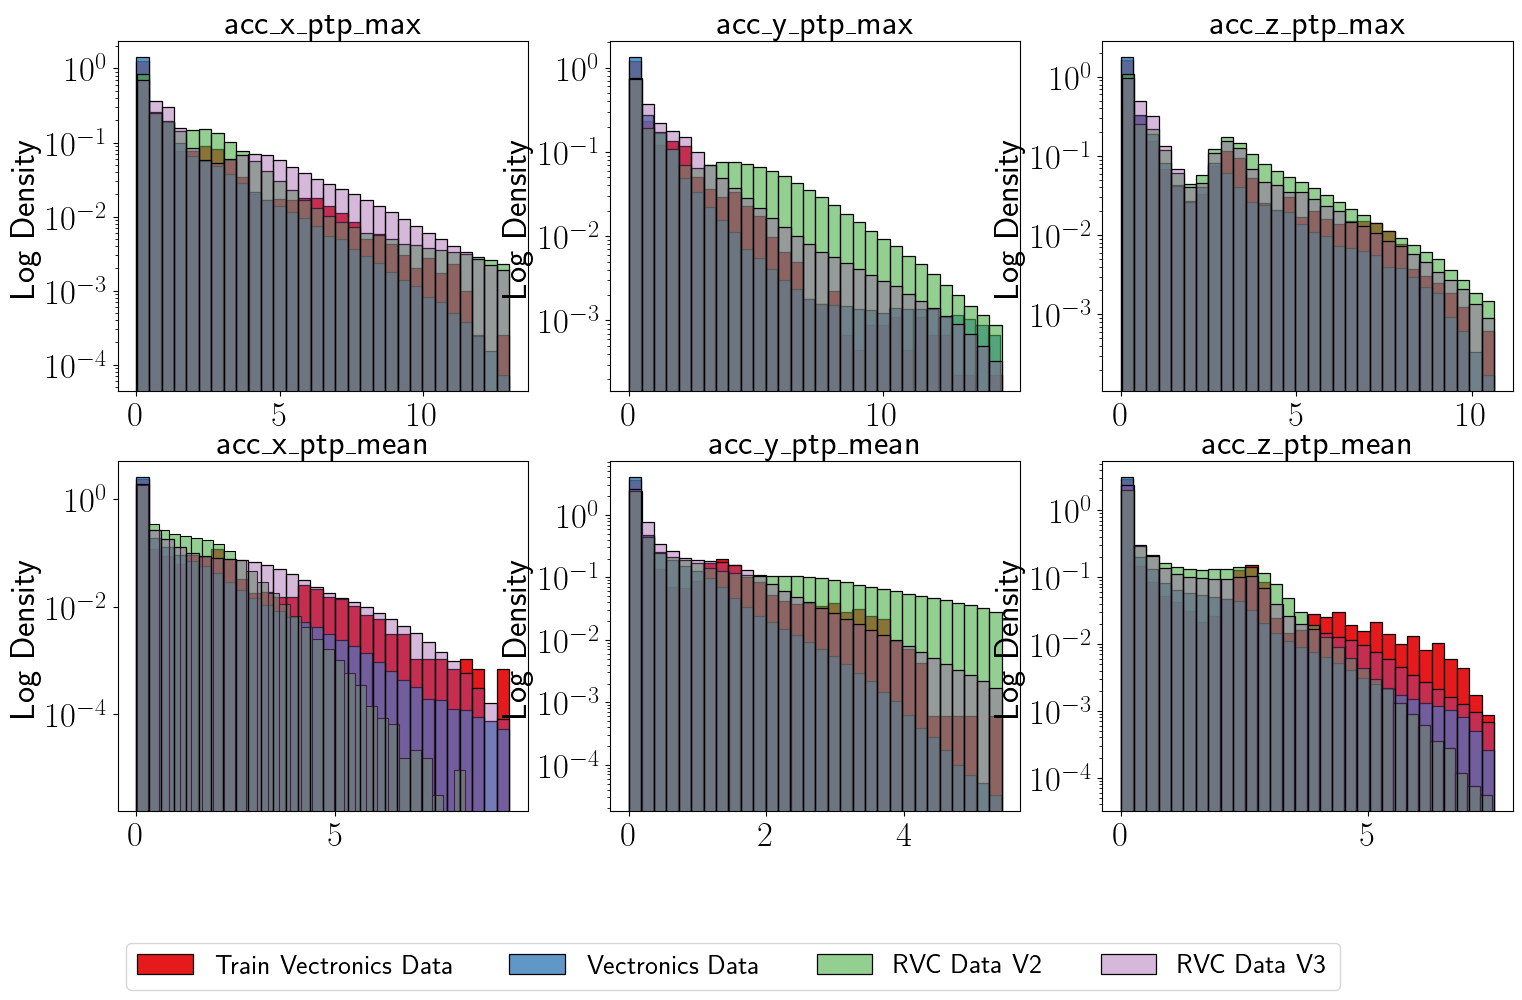

In [ ]:
def plot_histograms(X_src, X_src_full, Xt1, Xt2, feature_cols, transform=None, log=True):

    if transform is not None:
        X_src = transform(torch.tensor(X_src, dtype=torch.float32)).numpy()
        X_src_full = transform(torch.tensor(X_src_full, dtype=torch.float32)).numpy()
        Xt1 = transform(torch.tensor(Xt1, dtype=torch.float32)).numpy()
        Xt2 = transform(torch.tensor(Xt2, dtype=torch.float32)).numpy()

    # Plot histograms of features
    fig, axes = plt.subplots(len(feature_cols)//3, 3, figsize=(18, 5*(len(feature_cols)//3)))

    palette = sns.color_palette("Set1", n_colors=4)
    axes = axes.flatten()

    for i, col in enumerate(feature_cols):
            ax = axes[i]

            sns.histplot(
                    X_src[:,i],
                    kde=False,
                    label='Train Vectronics Data',
                    ax=ax,
                    stat='density',
                    bins=30,
                    color=palette[0],
                    alpha=1.0
                )
            
            sns.histplot(
                    X_src_full[:,i],
                    kde=False,
                    label='Vectronics Data',
                    ax=ax,
                    stat='density',
                    bins=30,
                    color=palette[1],
                    alpha=0.8
                )

            sns.histplot(Xt1[:,i],
                    kde=False,
                    label='RVC Data V2',
                    ax=ax,
                    stat='density',
                    bins=30,
                    color=palette[2],
                    alpha=0.6
                )
            sns.histplot(Xt2[:,i],
                    kde=False,
                    label='RVC Data V3',
                    ax=ax,
                    stat='density',
                    bins=30,
                    color=palette[3],
                    alpha=0.4
                )
        
            ax.set_title(col)
            if log:
                ax.set_ylabel('Log Density')
                ax.set_yscale('log')
            else:
                ax.set_ylabel('Density')
            ax.set_xlabel('')

    # Get legend info from the first axes
    handles, labels = axes[0].get_legend_handles_labels()
    axes[0].legend(handles, labels, loc='lower center', bbox_to_anchor=(1.5, -1.75), ncol=4)
    plt.show()

plot_histograms(X_src, X_src_full, Xt1, Xt2, Vectronics_feature_cols, transform=None)

The raw feature distributions are highly right-skewed, with most values concentrated near zero and a long tail extending to larger magnitudes. To reduce this skewness, we apply a log1p transformation, which compresses large values while preserving the relative structure of the data.

After the transformation, we normalize all six features to a common range of –1 to 1 to ensure consistent scaling across both source and target domains. This rescaling is implemented using a PyTorch transform object, which standardizes the features before training and evaluation.

In [10]:
pos_idx = [0, 1, 2, 3, 4, 5]  # Indices of features that are all positive
center_idx = None  # Indices of features that should be centered at zero

# compute global lows/highs once
lows, highs = preprocess.compute_combined_quantiles(
    datasets=[X_src],
    pos_idx=[0,1,2,3,4,5], center_idx=None,
    low_q=0.00,
    high_q=1.00,
)

# define transform
transform = preprocess.TransformAndScale(
    pos_idx=pos_idx,
    center_idx=center_idx,
    lows=lows,
    highs=highs,
    clip_to_quantile=False
)

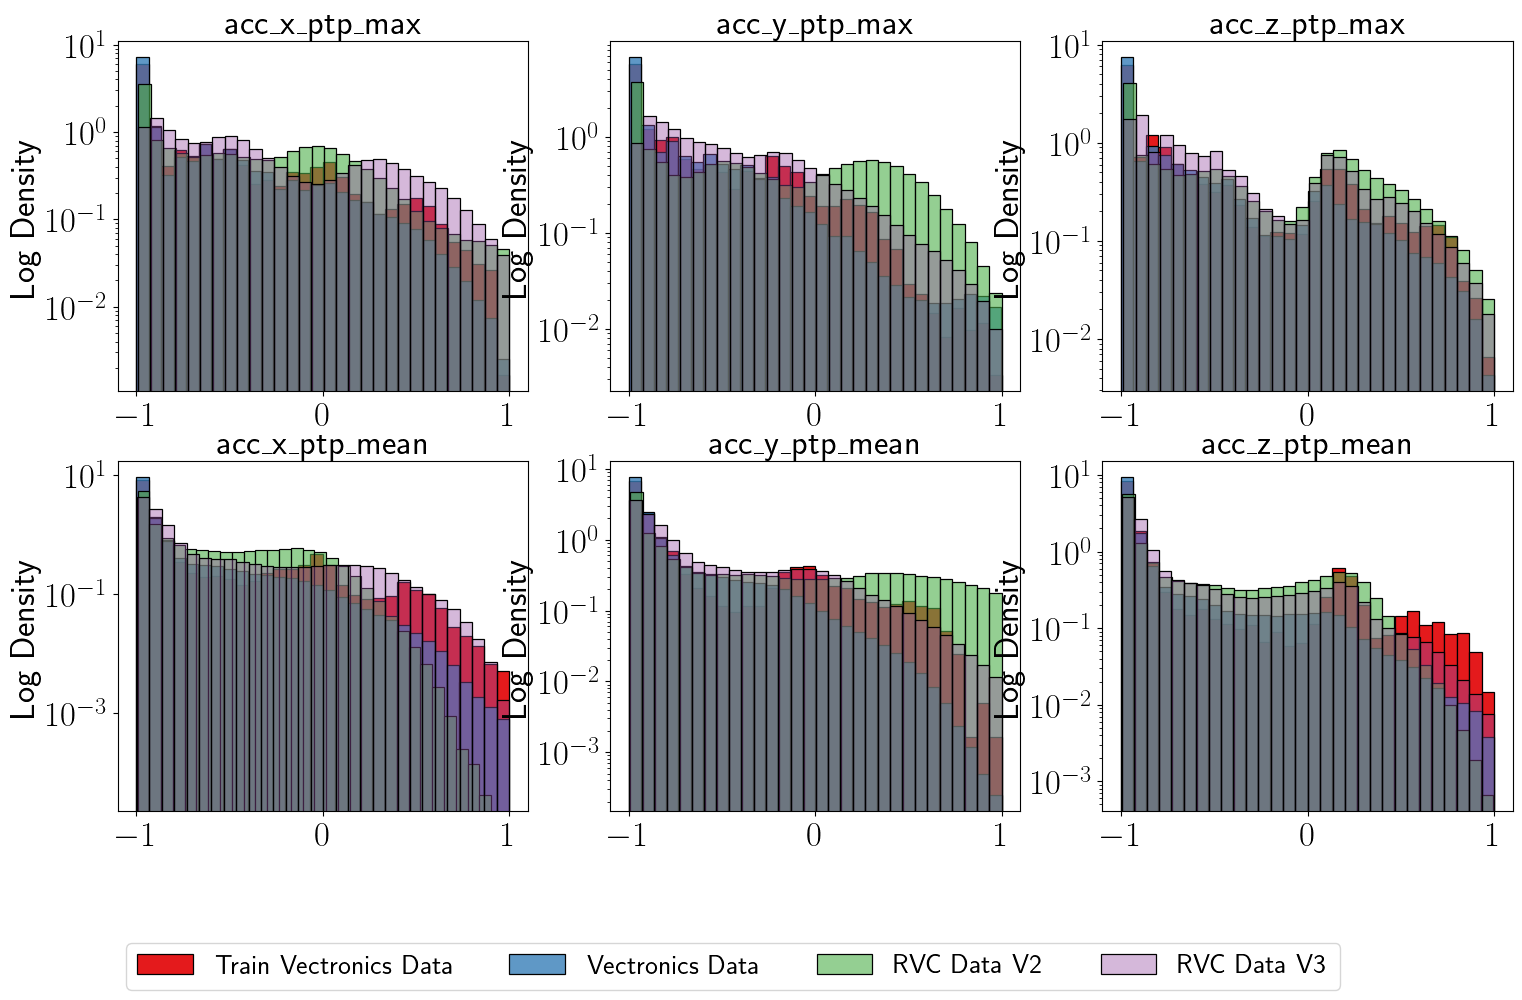

In [68]:
plot_histograms(X_src, X_src_full, Xt1, Xt2, Vectronics_feature_cols, transform=transform)

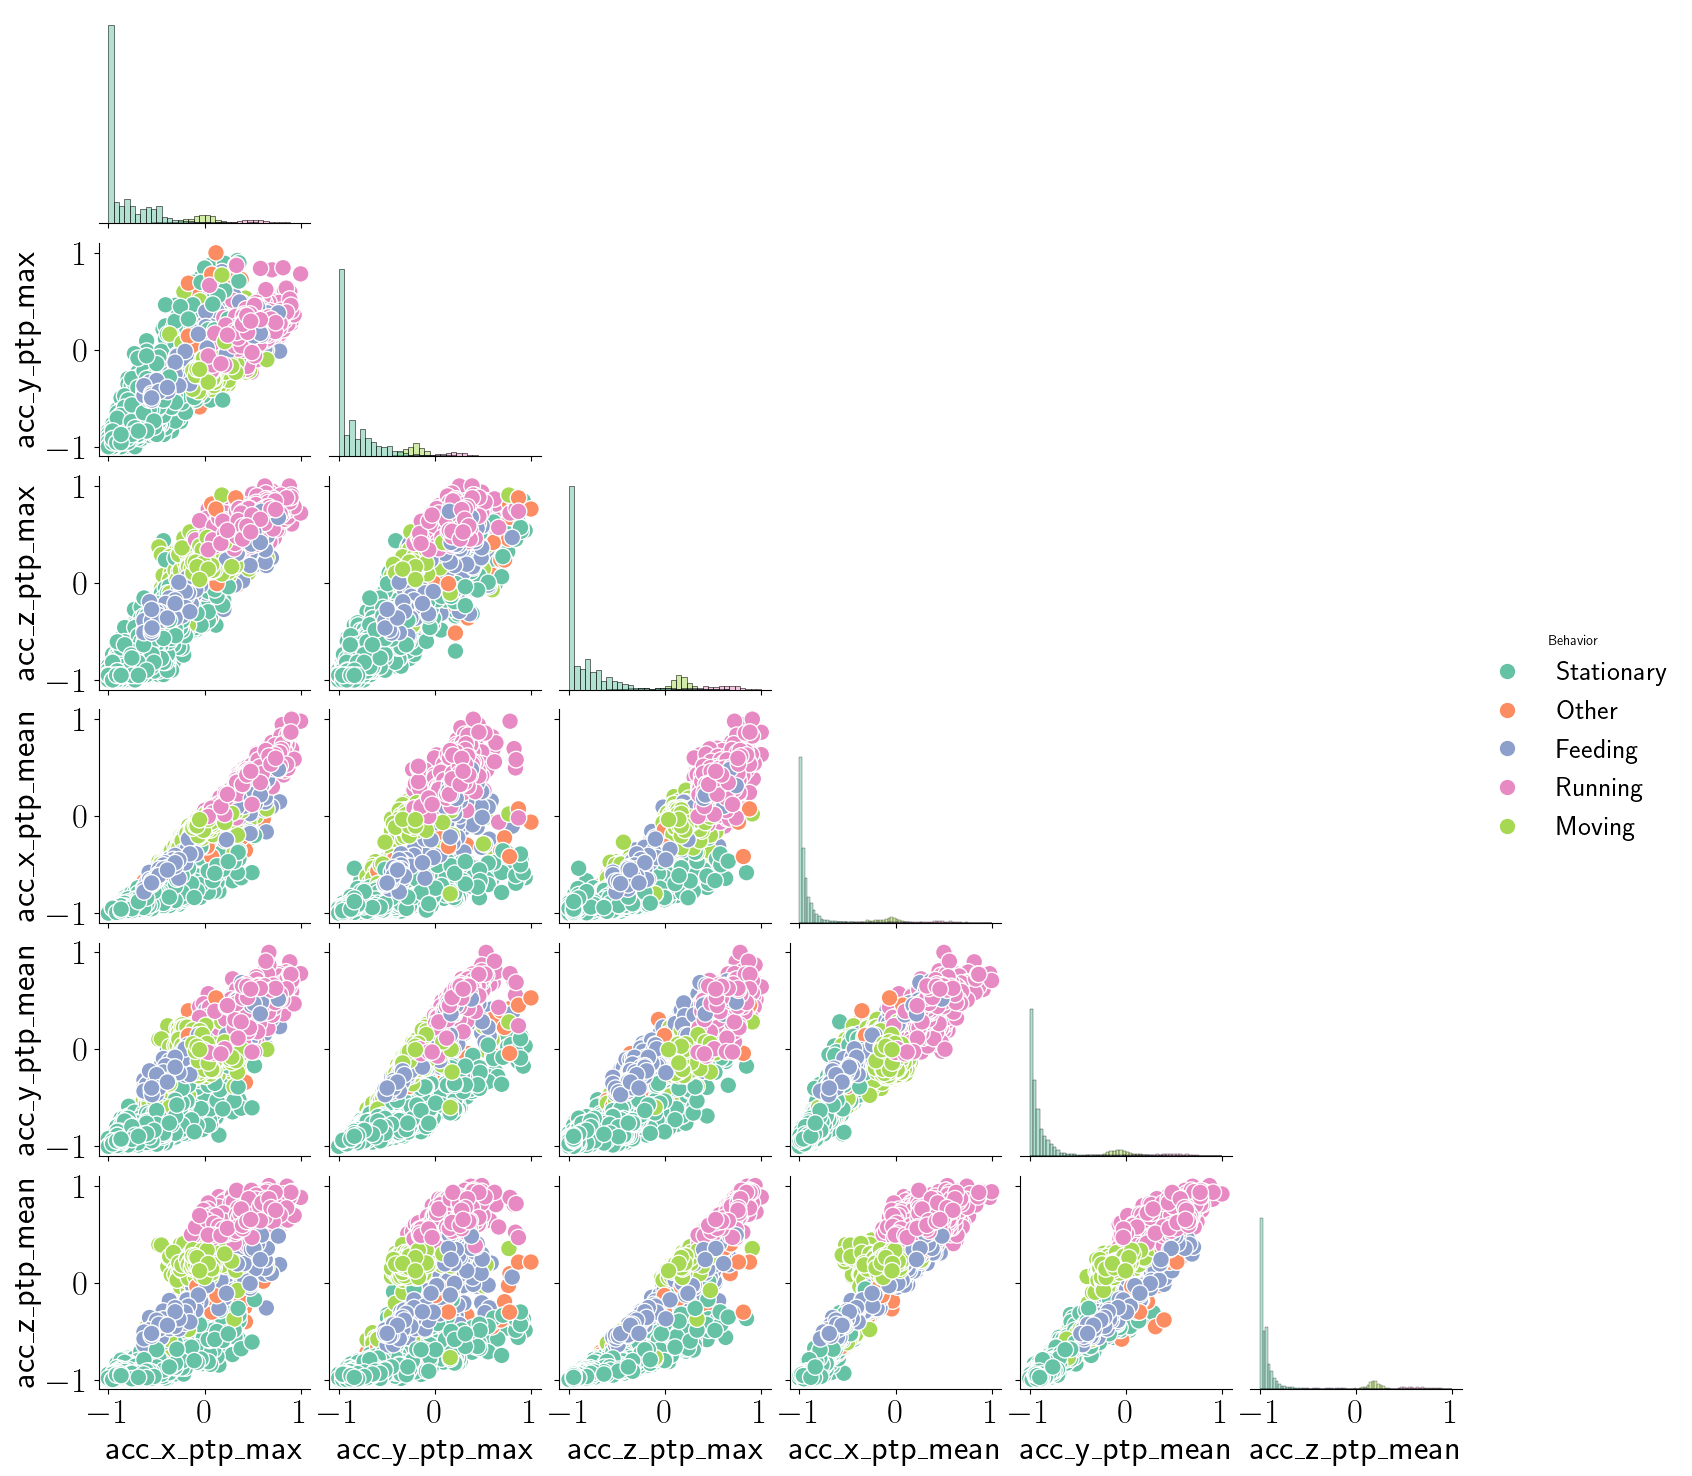

In [56]:
X_df = pd.DataFrame(X_src.numpy(), columns=Vectronics_feature_cols)
X_df['Behavior'] = label_encoder.inverse_transform(y_src.numpy())

sns.pairplot(X_df, hue='Behavior', corner=True, diag_kind='hist', palette='Set2')
plt.show()


### Load Validation Data for Sightings Plots

We next load the **validation set for RVC**, which contains weak labels used to generate *sightings plots*. These plots overlay the true signal, predicted scores, GPS-matched timestamps, detected movement events, and GPS-derived clusters. In this step, we load the required dataframes referenced by the plotting utility.

**Required columns in `matched_sightings`:**

* UTC time [yyyy-mm-dd HH:MM:SS]
* UTC date [yyyy-mm-dd]
* animal_id
* collar_number
* range
* firmware_major_version
* Sighting time [yyyy-mm-dd HH:MM:SS]

**Required columns in `matched_gps`:**

* UTC time
* latitude / longitude
* timestamp_prev
* time_diff [s]
* distance [m]
* collar_number
* animal_id
* UTC date

**Required columns in `gps_moving`:**

* animal_id
* collar_number
* timestamp_start / timestamp_end
* UTC date
* time_diff [s]
* distance [m]

**Required columns in `gps_clusters`:**

* animal_id
* collar_number
* timestamp_start / timestamp_end
* UTC date
* time_diff [s]
* distance [m]

> The `matched_gps`, `gps_moving`, and `gps_clusters` dataframes are optional and may be set to `None` if not available for the sightings visualizations.


In [11]:
# objects for evaluation

matched_sightings = pd.read_csv(io.get_sightings_path())
matched_gps = pd.read_csv(io.get_matched_gps_path())
gps_moving = pd.read_csv(io.get_gps_moving_path())
gps_clusters = pd.read_csv(io.get_gps_clusters_path())

group_ids = list(matched_sightings.groupby(['animal_id', 'UTC date [yyyy-mm-dd]']).groups.keys())
n_sightings_days = len(group_ids)
train_sightings, val_sightings, test_sightings = group_ids[:int(0.5*n_sightings_days)], group_ids[int(0.5*n_sightings_days): int(0.75*n_sightings_days)], group_ids[int(0.75*n_sightings_days): ]
RVC_labeled_mask = RVC_df['behavior'].notna()
test_mask = RVC_labeled_mask & RVC_df[['animal_id', 'UTC date [yyyy-mm-dd]']].apply(tuple, axis=1).isin(test_sightings)
X_sightings_test_set, y_sightings_test_set = RVC_df[test_mask][Vectronics_feature_cols].values, RVC_df[test_mask]['behavior'].values

X_sightings_test_set = transform(torch.tensor(X_sightings_test_set, dtype=torch.float32))
y_sightings_test_set = label_encoder.transform(y_sightings_test_set)
classes, counts = np.unique(y_sightings_test_set, return_counts=True)
print("VALIDATION TARGET DATA")
print(f"Total observations: {X_sightings_test_set.shape[0]}")
print(f"Class distribution:")
for cls, count in zip(classes, counts):
    print(f" - {cls}: {count}, ({count / X_sightings_test_set.shape[0]:.2%})")
print("")

VALIDATION TARGET DATA
Total observations: 6418
Class distribution:
 - 0: 282, (4.39%)
 - 1: 2217, (34.54%)
 - 4: 3919, (61.06%)



## Step 2 — Train the Prediction Model

We have identified that the two sensor versions in the RVC data are two different domains. Therefore, we train two different models, adjusting for the distribution shift from the source data to each of the target data.

In [ ]:
args.input_dim = X_src.shape[-1]
args.n_classes = len(label_encoder.classes_)

### Creating Dataloaders for Training

The dataloader performs two key operations during batch construction:

* **Transforms:** Applies the defined `transform` to each batch to ensure consistent preprocessing.
* **Dynamic class rebalancing:** Adjusts the class composition of each batch using the `args.theta` parameter, achieving the desired class distribution through controlled under- and oversampling.
 batch via under and oversampling.

In [23]:
n_classes = len(label_encoder.classes_)
X_train, X_temp, y_train, y_temp = train_test_split(X_src, y_src, test_size=2*args.test_frac, random_state=42, stratify=y_src)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
train_loader, val_loader, test_loader = setup_multilabel_dataloaders(X_train, y_train, X_val, y_val, X_test, y_test, args, n_outputs=n_classes, transform=transform)
print("SOURCE DATA SPLITS")
print(f"Train data: {X_train.shape}")
print(f"Val data: {X_val.shape}")
print(f"Test data: {X_test.shape}")
print("")

target_train_loaders = []
target_test_loaders = []

for i, Xt in enumerate([Xt1, Xt2]):

    idx = np.random.permutation(len(Xt))
    target_train_idx = idx[:X_train.shape[0]]
    target_test_idx = idx[X_train.shape[0]:]  # remaining go to test

    X_target_train, X_target_test = Xt[target_train_idx], Xt[target_test_idx]

    # Build target train/test datasets
    target_train_dataset = datasets.NumpyDataset(X=X_target_train, y=None, transform=transform)
    target_test_dataset  = datasets.NumpyDataset(X=X_target_test, y=None, transform=transform)

    # Create loaders
    target_train_loader = DataLoader(target_train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=4, pin_memory=True)
    target_test_loader  = DataLoader(target_test_dataset,  batch_size=args.batch_size, shuffle=False, num_workers=4, pin_memory=True)

    target_train_loaders.append(target_train_loader)
    target_test_loaders.append(target_test_loader)
    
    print(f"TARGET-{i+1} DATA SPLITS")
    print(f"Train data: {X_target_train.shape}")
    print(f"Test data: {X_target_test.shape}")
    print("")

SOURCE DATA SPLITS
Train data: (5509, 6)
Val data: (1836, 6)
Test data: (1837, 6)

TARGET-1 DATA SPLITS
Train data: (5509, 6)
Test data: (1170694, 6)

TARGET-2 DATA SPLITS
Train data: (5509, 6)
Test data: (4399983, 6)



In [ ]:
for i, loader in enumerate(target_train_loaders):

    print(f"Training CORAL for target domain {i+1}...")

    # ---------------- Train CORAL ----------------
    results = train_coral(train_loader, val_loader, test_loader, loader, args, device)
    model = results['model']

    # ----------- Save Training Objects -----------
    dir = os.path.join(results_dir, f'target{i+1}')
    os.makedirs(dir, exist_ok=True)

    # (1) save model
    torch.save(model.state_dict(), os.path.join(dir, 'model.pt'))

    # save training statistics
    json_training_stats_file = os.path.join(dir, 'training_stats.json')
    with open(json_training_stats_file, 'w') as f:
        json.dump(results['training_stats'], f, indent=4)

    # (2) save test results
    test_results_path = os.path.join(dir, 'test_results.npz')
    np.savez(
    test_results_path,
    true_classes=results['test_true_classes'],
    predictions=results['test_predictions'],
    scores=results['test_scores'])

    # (3) save validation results
    val_results_path = os.path.join(dir, 'val_results.npz')
    np.savez(
        val_results_path,
        true_classes=results['val_true_classes'],
        predictions=results['val_predictions'],
        scores=results['val_scores'])
    
    # ----------- Evaluation -----------

    # evaluate label distribution on target test set
    _, _, _ = evaluate_multilabel_distribution(model=model, 
                                        data=target_test_loaders[i],
                                        label_encoder=label_encoder,
                                        device=device, 
                                        threshold=0.5,
                                        verbose=True)
    
    print(f"Finished training and evaluation for target domain {i+1}.\n")
    print(f"----------------------------------------\n")
    print(f'Results saved to {dir}\n')

## Step 3 — Model Evaluation

First, we evaluate the trained model on the **held-out test set from the source domain** to assess its baseline predictive performance.

Next, we generate predictions for the **full unlabeled source and target datasets** and examine the resulting label distribution. The disproportionately high percentage of *Feeding* predictions highlights a **distribution shift–induced miscalibration** in the model’s outputs.


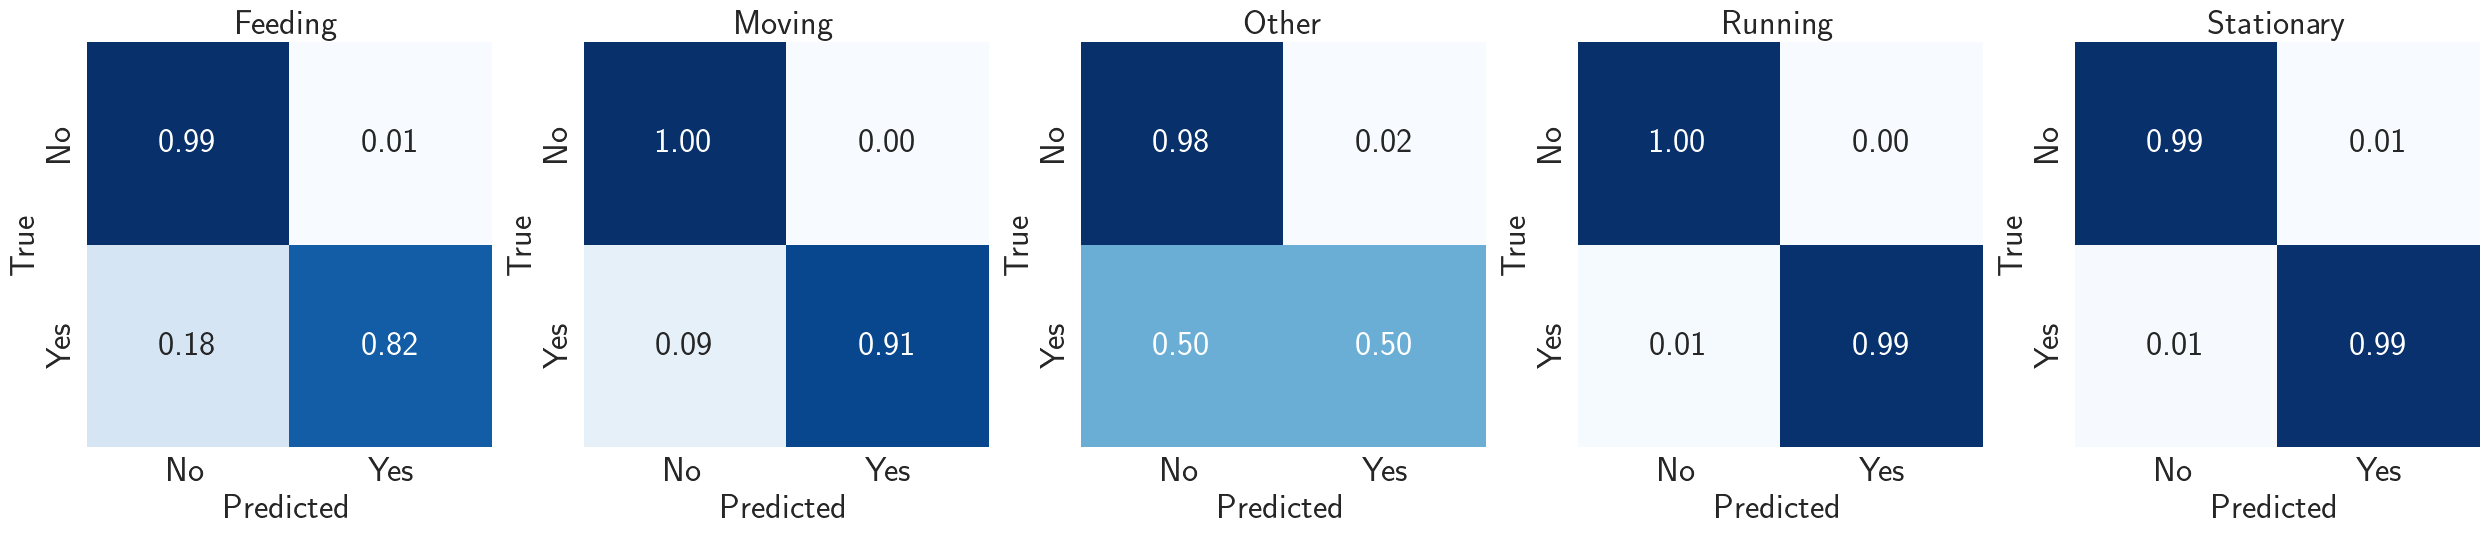

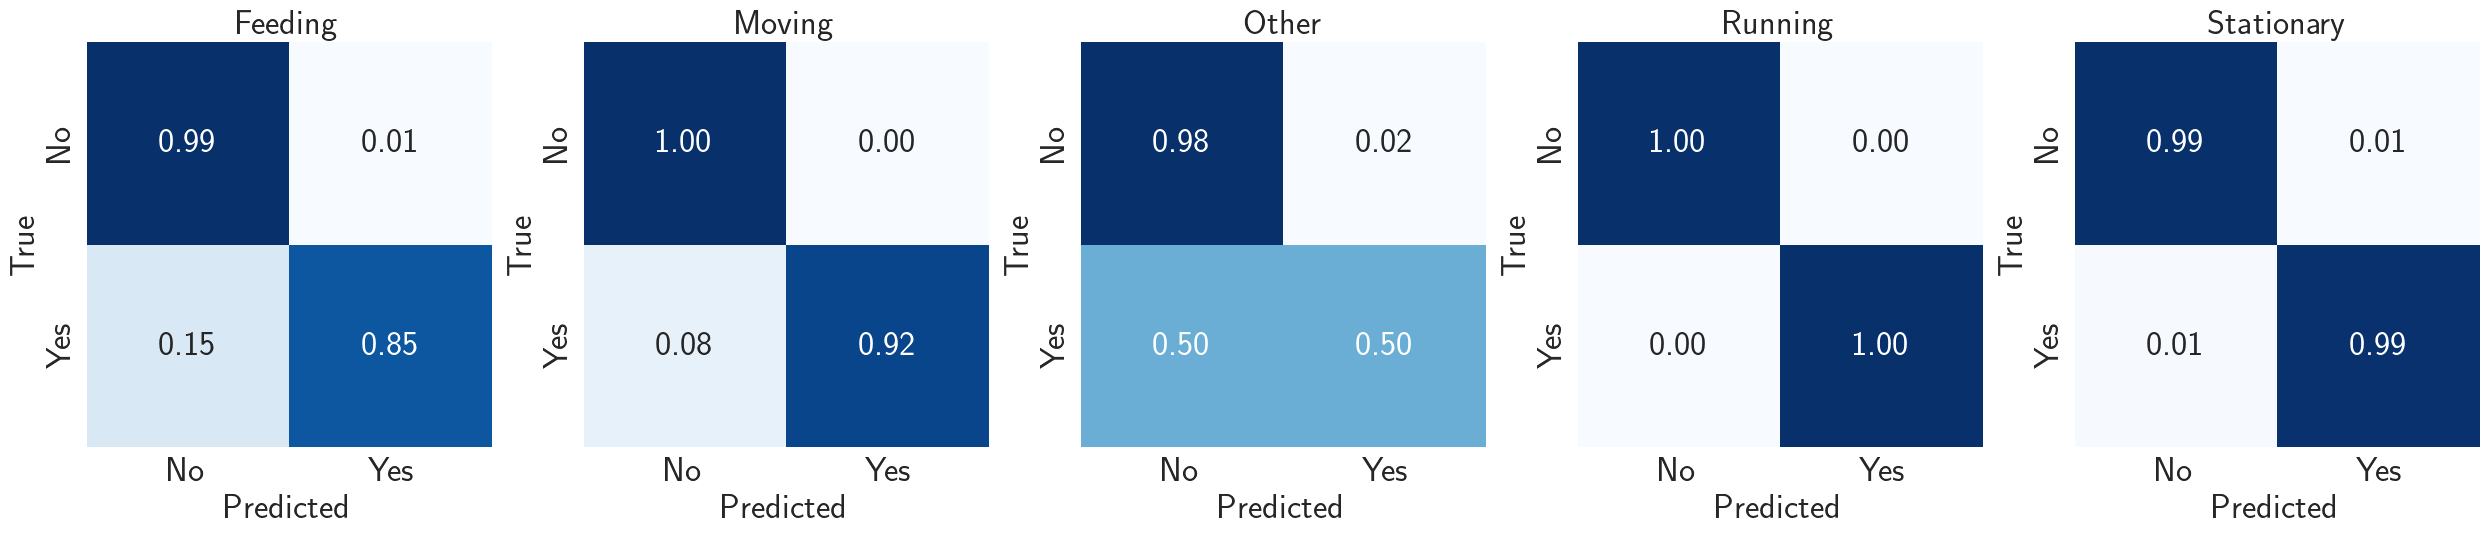

{}

In [25]:
dir1 = os.path.join(results_dir, "target1")
dir2 = os.path.join(results_dir, "target2")

multi_label_predictions(dir1, label_encoder, split='test', plot_confusion=True, return_precision=False)
multi_label_predictions(dir2, label_encoder, split='test', plot_confusion=True, return_precision=False)

In [26]:
source_loader = DataLoader(transform(torch.tensor(X_src_full, dtype=torch.float32)), batch_size=1024, shuffle=True, num_workers=4, pin_memory=True)
target_loaders = [DataLoader(transform(torch.tensor(Xt1, dtype=torch.float32)), batch_size=1024, shuffle=True, num_workers=4, pin_memory=True),
                  DataLoader(transform(torch.tensor(Xt2, dtype=torch.float32)), batch_size=1024, shuffle=True, num_workers=4, pin_memory=True) ]

In [27]:
feat_dim = 128

for i, dir_path in enumerate([dir1, dir2]):
    coral_model = SimpleFeatureNet(X_src.shape[-1], feat_dim, len(np.unique(y_src)))
    coral_model.load_state_dict(torch.load(os.path.join(dir_path, 'model.pt'), map_location=device))
    coral_model.to(device)
    print(f"Evaluating CORAL model for target domain {i+1}...")

    print("PREDICTED SOURCE LABEL DISTRIBUTION:")
    _, _, _ = evaluate_multilabel_distribution(model=coral_model, 
                                    data=source_loader,
                                    label_encoder=label_encoder,
                                    device=device, 
                                    threshold=0.5)

    print("PREDICTED TARGET LABEL DISTRIBUTION:")
    _, _, _ = evaluate_multilabel_distribution(model=coral_model, 
                                    data=target_loaders[i],
                                    label_encoder=label_encoder,
                                    device=device, 
                                    threshold=0.5)


Evaluating CORAL model for target domain 1...
PREDICTED SOURCE LABEL DISTRIBUTION:


/tmp/ipykernel_3608872/1462004492.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  coral_model.load_state_dict(torch.load(os.path.join(dir_path, 'model.pt'), map_location


Predicted class % occurrence:
  Feeding: 1.18%
  Moving: 6.63%
  Other: 4.27%
  Running: 1.43%
  Stationary: 84.15%
PREDICTED TARGET LABEL DISTRIBUTION:

Predicted class % occurrence:
  Feeding: 19.26%
  Moving: 2.61%
  Other: 10.63%
  Running: 3.47%
  Stationary: 57.03%
Evaluating CORAL model for target domain 2...
PREDICTED SOURCE LABEL DISTRIBUTION:


/tmp/ipykernel_3608872/1462004492.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  coral_model.load_state_dict(torch.load(os.path.join(dir_path, 'model.pt'), map_location


Predicted class % occurrence:
  Feeding: 1.19%
  Moving: 6.87%
  Other: 4.59%
  Running: 1.65%
  Stationary: 84.58%
PREDICTED TARGET LABEL DISTRIBUTION:

Predicted class % occurrence:
  Feeding: 5.33%
  Moving: 9.60%
  Other: 11.32%
  Running: 4.06%
  Stationary: 68.32%


/tmp/ipykernel_3608872/1698476298.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  coral_model2.load_state_dict(torch.load(os.path.join(dir2, 'model.pt'), map_location=de

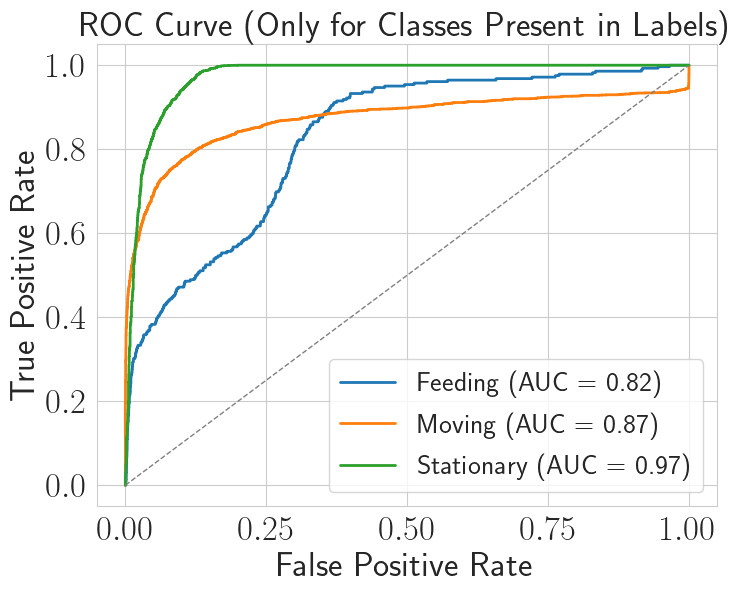

In [28]:
coral_model2 = SimpleFeatureNet(X_src.shape[-1], feat_dim, len(np.unique(y_src)))
coral_model2.load_state_dict(torch.load(os.path.join(dir2, 'model.pt'), map_location=device))
coral_model2.to(device)

with torch.no_grad():
    _, logits = coral_model2(torch.tensor(X_sightings_test_set, dtype=torch.float32).to(device))
    predictions = torch.sigmoid(logits).detach().cpu().numpy()

plot_multiclass_roc(y_sightings_test_set, predictions, label_encoder=label_encoder)

## Step 3 — Calibration

As observed above, the model’s predictions on the RVC dataset yield ecologically unrealistic label proportions, particularly an inflated rate of *Feeding* predictions. To address this, we apply a calibration procedure that adjusts the predicted scores to align with a user-defined **“golden” reference label distribution**.


In [ ]:
N_CLUSTERS, CLUSTER_BATCH_SIZE = 100, 10000
feat_dim = 128
reg = 0.01

cluster_dist1, cluster_centroids1, cluster_labels1, kmeans1 = func.compute_kmeans_distribution(transform(torch.tensor(Xt1, dtype=torch.float32)), n_clusters=N_CLUSTERS, batch_size=CLUSTER_BATCH_SIZE, random_state=42)
cluster_dist2, cluster_centroids2, cluster_labels2, kmeans2 = func.compute_kmeans_distribution(transform(torch.tensor(Xt2, dtype=torch.float32)), n_clusters=N_CLUSTERS, batch_size=CLUSTER_BATCH_SIZE, random_state=42)
label_dist = np.array([2.55, 4.48, 3.55, 1.96, 87.45])

In [32]:
coral_model1 = SimpleFeatureNet(X_src.shape[-1], feat_dim, len(np.unique(y_src)))
coral_model1.load_state_dict(torch.load(os.path.join(dir1, 'model.pt'), map_location=device))
coral_model1.to(device)

coral_model2 = SimpleFeatureNet(X_src.shape[-1], feat_dim, len(np.unique(y_src)))
coral_model2.load_state_dict(torch.load(os.path.join(dir2, 'model.pt'), map_location=device))
coral_model2.to(device)

P1, cluster_scores1, unadjusted_label_dist1, adjusted_label_dist1, adjusted_scores1, predictions1 = calibration(cluster_dist1, cluster_centroids1, cluster_labels1, coral_model1, label_dist=label_dist, reg=reg)
P2, cluster_scores2, unadjusted_label_dist2, adjusted_label_dist2, adjusted_scores2, predictions2 = calibration(cluster_dist2, cluster_centroids2, cluster_labels2, coral_model2, label_dist=label_dist, reg=reg)

/tmp/ipykernel_3608872/3109854598.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  coral_model1.load_state_dict(torch.load(os.path.join(dir1, 'model.pt'), map_location=de

In [ ]:
# # make calibrated sightings plots
# plot_dir = os.path.join(io.get_sightings_dir(), 'coral', args.label_config, 'calibrated')

# _ = make_sightings_plots_from_clusters(cluster_labels=cluster_labels2,
#                                    cluster_scores=adjusted_scores2,
#                                    data=transform(torch.tensor(X_targets[1][Vectronics_feature_cols].values, dtype=torch.float32)),
#                                    metadata=X_targets[1],
#                                    matched_sightings=sightings, 
#                                    matched_gps=matched_gps,
#                                    gps_clusters=gps_clusters,
#                                    matched_gps_moving=gps_moving, 
#                                    predictions=predictions2,
#                                    plot_dir=plot_dir,
#                                    save_predictions=True)